# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [4]:
import torch

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cuda'

In [7]:
from torchtext.datasets import SQuAD1

In [8]:
train, test = SQuAD1("root")

In [9]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [10]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [11]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [13]:
train_len = 15000
test_len = 3000

In [14]:
train_df = sample_df_num(train_df, train_len)

In [15]:
test_df = sample_df_num(test_df, test_len)

In [16]:
train_df.shape, test_df.shape

((15000, 2), (3000, 2))

In [18]:
train_df.head(3)

,Question,Answer
0,"In Devon, Jan is another way of saying what co...",John
1,Where were most jazz clubs located?,cellars
2,"Who was known by the nickname ""the Grammarian""?",Ælfric of Eynsham


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [19]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

In 2004, how many physicians did Eritrea have per 1000 people?
['2004', 'how', 'many', 'physicians', 'eritrea', 'per', '1000', 'people']
['2004', 'how', 'mani', 'physician', 'eritrea', 'per', '1000', 'peopl']


In [20]:
from modules.vocab import Vocab

In [21]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [22]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [23]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
11802,WHat are some festivals or events of note in C...,"the Cork Jazz Festival, Cork Film Festival, an...","[what, festiv, event, note, cork]","[cork, jazz, festival, cork, film, festival, l..."
9538,What is the entity that controls the infrastru...,The Greater Hyderabad Municipal Corporation (G...,"[what, entiti, control, infrastructur, hyderabad]","[greater, hyderabad, municipal, corporation, g..."
14755,What farmers are generally less dependent on c...,polyculture farmers,"[what, farmer, general, less, depend, capit, b...","[polyculture, farmers]"


In [24]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [25]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [26]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [27]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [28]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [29]:
Q_vocab.n_words, A_vocab.n_words, 

(11897, 14642)

In [30]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [76]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(13184, 16442)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [32]:
from modules.stats import sentences_stats, histograms

In [33]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.42
	         median: 6.00
	         minimum: 1
	         maximum: 20)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 21)


In [34]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.52
	         median: 6.00
	         minimum: 2
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.34
	         median: 2.00
	         minimum: 0
	         maximum: 15)


### Remove the least common words from the sentences

In [35]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [43]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 6875 words that occur only once, answers vocabulary has 10427 such words


### Create lists of those words and remove them from the sequences

In [45]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [46]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [49]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [50]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.03
	         median: 6.00
	         minimum: 0
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 1.84
	         median: 1.00
	         minimum: 0
	         maximum: 18)


In [51]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.18
	         median: 6.00
	         minimum: 1
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 1.81
	         median: 1.00
	         minimum: 0
	         maximum: 13)


### Remove questions that have less than three words and answers that have less than one

In [52]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


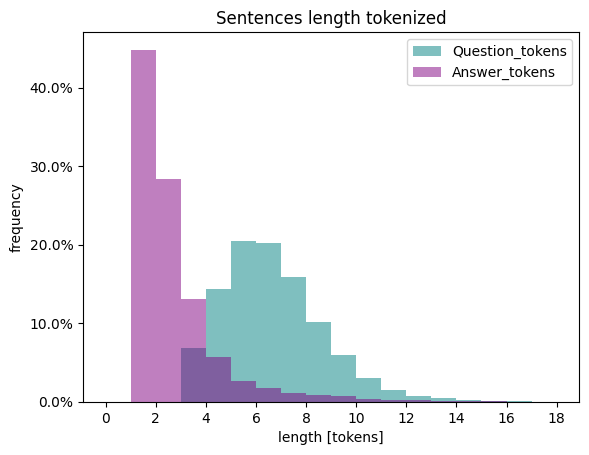

In [56]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [57]:
train_df_final.shape

(12208, 4)

In [58]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.15
	         median: 6.00
	         minimum: 3
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.20
	         median: 2.00
	         minimum: 1
	         maximum: 18)


In [59]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


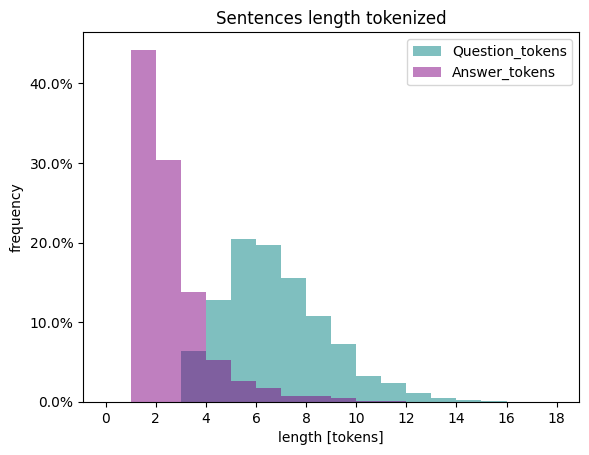

In [60]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [61]:
test_df_final.shape

(2507, 4)

In [62]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.30
	         median: 6.00
	         minimum: 3
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.10
	         median: 2.00
	         minimum: 1
	         maximum: 13)


### Remove long outliers: long sentences that occure rarely

In [63]:
# keeping only the 95% of the data
cutoff = 95

In [65]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [66]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [67]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [68]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.98
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.95
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [ ]:
# to simplify I'm using the same thresholds for the test set

In [70]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [71]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.09
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.95
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [72]:
train_df_final.shape, test_df_final.shape

((11396, 4), (2350, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [73]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [74]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [75]:
len(train_pairs_final), len(test_pairs_final)

(11396, 2350)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [80]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        #self.hidden = torch.zeros(1, 1, hidden_size)

        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # The LSTM is our last cell because it produces the hidden state        
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        
        x = x.view(1, 1, -1)
        
        #x = x.view(x.shape[0], 1, -1)
        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # The LSTM produces an output by passing the hidden state to the   Linear layer
    
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

    
    

class Seq2Seq(nn.Module):

    #def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    
        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
        #self.device = device
        
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        max_len, batch_size = trg_batch.shape
                
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        
        
        trg = trg_batch[0]
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

### Model parameters

In [81]:
embedding_dim = 256
hidden_size = 256

### Hyperparameters

In [82]:
learning_rate = 0.02
num_epochs = 25

### Model

In [83]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [84]:
seq2seq = seq2seq.to(device)

### Optimizer and loss function

In [86]:
from torch import optim
import torch.nn as nn

In [87]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [94]:
def train(model, pairs, optimizer, criterion, device, print_every = 1000):
    model.train()  # Set the model to training mode
    
    total_loss = 0

    count = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
        count += 1 
    
        if count % print_every == 0:
            print(f'Loss {total_loss/count}')
    
    return total_loss / len(pairs)

In [95]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Loss 2.896788510918617
Loss 2.8843258559703826
Loss 2.8701288826465605
Loss 2.8600253076851367
Loss 2.8596812101840974
Loss 2.860042496035496
Loss 2.8675633597459114
Loss 2.867697256706655
Loss 2.868524100734128
Loss 2.8657100514113902
Loss 2.8726741312904793
Epoch 1/25, Loss: 2.8725
Loss 2.801761792302132
Loss 2.7923690365552902
Loss 2.7833784093459446
Loss 2.7770653677284716
Loss 2.7787087182998658
Loss 2.7802628721892835
Loss 2.788419612518379
Loss 2.7895102889463304
Loss 2.790814852244324
Loss 2.788739923709631
Loss 2.794068969060074
Epoch 2/25, Loss: 2.7934
Loss 2.7397070373296737
Loss 2.7249385855197907
Loss 2.714865869084994
Loss 2.7086751225292685
Loss 2.7105776330351827
Loss 2.71241231200099
Loss 2.719501905143261
Loss 2.7203050287291406
Loss 2.7212875068386397
Loss 2.7193700462400914
Loss 2.7231963904283263
Epoch 3/25, Loss: 2.7220
Loss 2.673307354092598
Loss 2.6543726925253868
Loss 2.642683626214663
Loss 2.6389861545562745
Loss 2.640890316307545
Loss 2.6426272546251615
Loss 